In [ ]:
import os
import random
import sys
import pickle

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm import tqdm

In [ ]:
# from google.colab import drive, files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
checkpoint = ModelCheckpoint("inceptionV3.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [ ]:
def plot_images(dataset, label0, label1):
  """
  Plots a sample of images from the dataset.

  Args:
      dataset (list): List containing tuples of image data and corresponding labels.
      label0 (str): Label for category 0.
      label1 (str): Label for category 1.

  Returns:
      None
  """
  plt.figure(figsize=(10,6))
  for i in range(8):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = dataset[sample][1]
    if category == 0:
        label = label0
    else:
        label = label1
    plt.subplot(2,4,i+1)
    plt.imshow(image_rgb)
    plt.xlabel(label)
  plt.tight_layout()
  plt.show()

In [ ]:
def define_train_test_valid(dataset, image_size):
  """
  Defines training, testing, and validation sets from the dataset.

  Args:
      dataset (list): List containing tuples of image data and corresponding labels.
      image_size (int): Size of the images.

  Returns:
      tuple: A tuple containing six arrays:
          - x_train (numpy.ndarray): Features for training.
          - x_validation (numpy.ndarray): Features for validation.
          - x_test (numpy.ndarray): Features for testing.
          - y_train (numpy.ndarray): Target labels for training.
          - y_validation (numpy.ndarray): Target labels for validation.
          - y_test (numpy.ndarray): Target labels for testing.
  """

  #Deviding dataset into x(features and y(target))
  x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
  y = np.array([i[1] for i in dataset])

  # Normalize Features
  x = x.astype(np.float32)

  # Normalize the image to the range [0, 1]
  x = x / 255.0

  # Split in training testing and validation
  x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
  x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

  return x_train, x_validation, x_test, y_train, y_validation, y_test

In [ ]:
def plot_cm(cm):
  """
  Plots the confusion matrix.

  Args:
      cm (numpy.ndarray): Confusion matrix.

  Returns:
      None
  """
  plt.figure(figsize=(8, 6))
  sns.set(font_scale=1.2)  # Adjust the font scale for better readability
  sns.heatmap(cm.astype(int), annot=True, fmt=".2f", cmap="Blues",
              xticklabels=['Normal', 'Cataract'],
              yticklabels=['Normal', 'Cataract'])

  plt.text(0.5, 0.6, 'TP', ha='center', va='center', fontweight='bold', color='red')
  plt.text(0.5, 1.6, 'FP', ha='center', va='center', fontweight='bold', color='red')
  plt.text(1.5, 0.6, 'FN', ha='center', va='center', fontweight='bold', color='red')
  plt.text(1.5, 1.6, 'TN', ha='center', va='center', fontweight='bold', color='red')

  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix")
  plt.show()

In [ ]:
def plot_train_valid_results(hist):
  """
  Plots the training and validation loss and accuracy over epochs.

  Args:
      hist (tf.keras.callbacks.History): History object containing training metrics.

  Returns:
      None
  """
  # Plot training and validation loss
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(hist.history['loss'], label='Training Loss')
  plt.plot(hist.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plot training and validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(hist.history['accuracy'], label='Training Accuracy')
  plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

# *INCEPTION* MODEL : BINARY CLASSIFICATION

In [ ]:
image_size=224
InceptionV3 = InceptionV3(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# Freeze layers so they don’t change during training

# Freezing the layers from the pre-trained model is vital.
# This is because you don’t want the weights in those layers to be re-initialized.
# If they are, then you will lose all the learning that has already taken place.
# This will be no different from training the model from scratch.
for layer in InceptionV3.layers:
    layer.trainable = False

In [ ]:
x = tf.keras.layers.Flatten()( InceptionV3.output )
outputs = tf.keras.layers.Dense(1, activation='sigmoid')( x )

model = tf.keras.models.Model( InceptionV3.input , outputs )


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
model.save('/content/gdrive/MyDrive/DL_files/binary_model.keras')

CATARACT

In [ ]:
# LOAD THE DATASET

# For binary Normal-Cataract
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/cataract_dataset.pkl', 'rb') as file:
    dataset_nc = pickle.load(file)

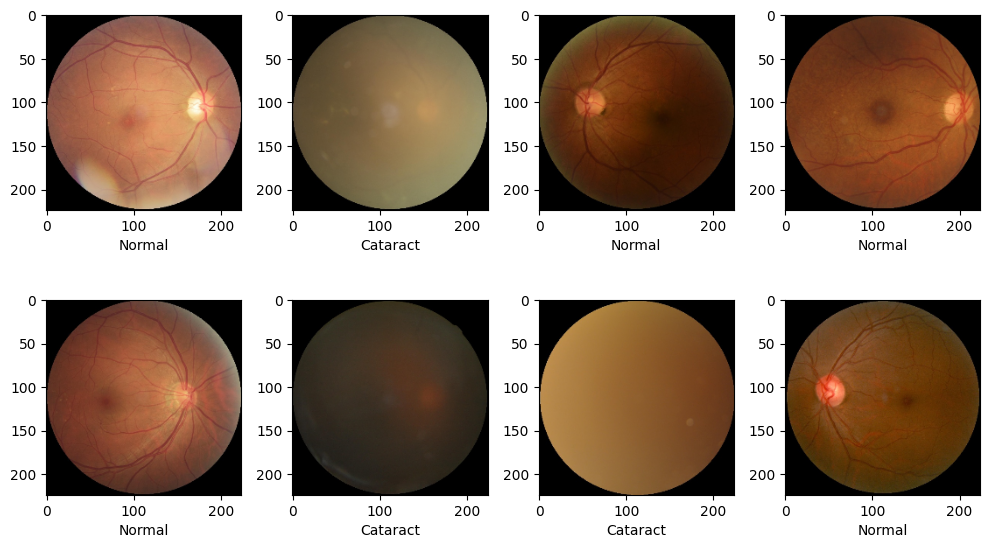

In [ ]:
plot_images(dataset_nc, "Normal", "Cataract")

In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test = define_train_test_valid(dataset_nc, image_size)

Epoch 1/15
29/29 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.8822
Epoch 1: val_accuracy improved from -inf to 0.96429, saving model to inceptionV3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/29 [==============================] - 18s 295ms/step - loss: 0.5742 - accuracy: 0.8822 - val_loss: 0.3118 - val_accuracy: 0.9643
Epoch 2/15
28/29 [===========================>..] - ETA: 0s - loss: 0.1502 - accuracy: 0.9632
Epoch 2: val_accuracy improved from 0.96429 to 0.97321, saving model to inceptionV3.h5
29/29 [==============================] - 3s 100ms/step - loss: 0.1495 - accuracy: 0.9633 - val_loss: 0.1370 - val_accuracy: 0.9732
Epoch 3/15
28/29 [===========================>..] - ETA: 0s - loss: 0.0464 - accuracy: 0.9844
Epoch 3: val_accuracy did not improve from 0.97321
29/29 [==============================] - 2s 79ms/step - loss: 0.0463 - accuracy: 0.9844 - val_loss: 0.1862 - val_accuracy: 0.9554
Epoch 4/15
28/29 [===========================>..] - ETA: 0s - loss: 0.0216 - accuracy: 0.9922
Epoch 4: val_accuracy did not improve from 0.97321
29/29 [==============================] - 2s 79ms/step - loss: 0.0215 - accuracy: 0.9922 - val_loss: 0.1511 - val_accuracy: 0.9643
Epoch 

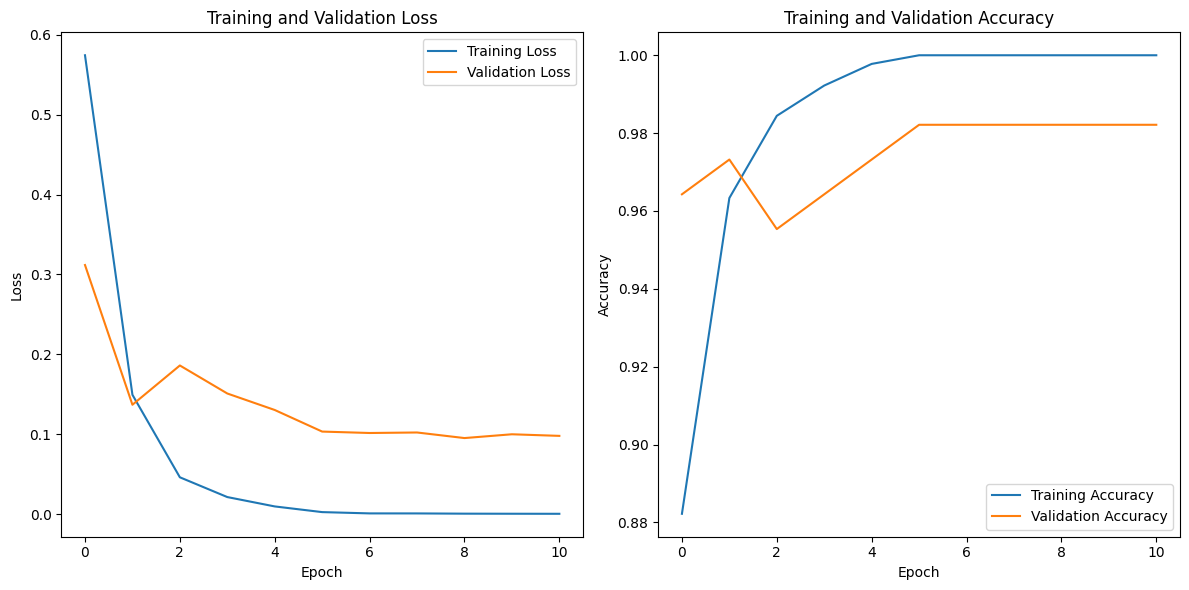

In [ ]:
model_cataract = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

history = model_cataract.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_validation,y_validation),verbose=1,
                             callbacks=[checkpoint,earlystop])

model_cataract.save('/content/gdrive/MyDrive/DL_files/cataract_model.keras')

plot_train_valid_results(history)

In [ ]:
model_cataract_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/cataract_model.keras')


In [ ]:
loss,accuracy = model_cataract_testing.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 5s 772ms/step - loss: 0.3784 - accuracy: 0.9292
loss: 0.37842586636543274
Accuracy: 0.9292035102844238


In [ ]:
y_pred = model_cataract_testing.predict(x_test)

4/4 [==============================] - 1s 62ms/step


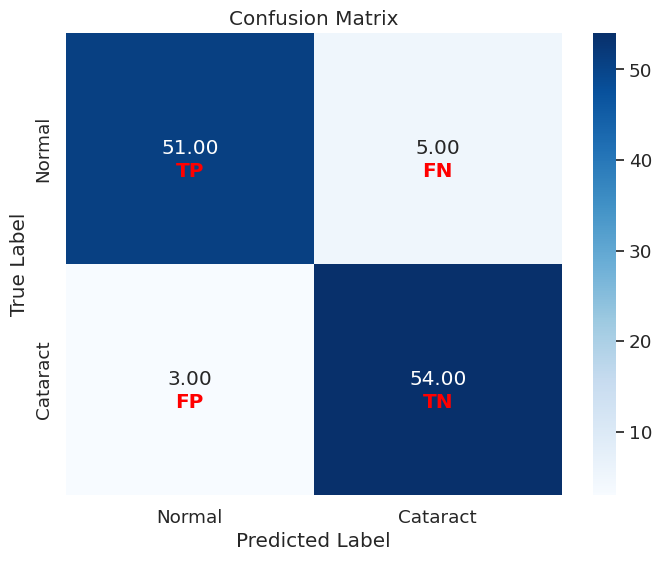

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
plot_cm(cm)

DIABETIC RETINOPATHY

In [ ]:
# LOAD DATASET

# For binary Normal-Diabetes
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/diabetes_dataset.pkl', 'rb') as file:
    dataset_nd = pickle.load(file)

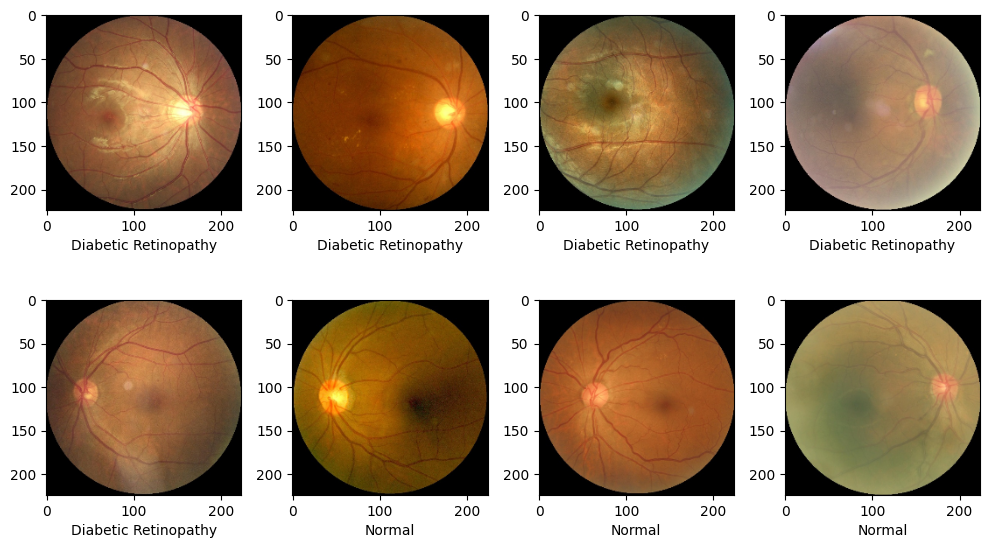

In [ ]:
plot_images(dataset_nd, "Normal", "Diabetic Retinopathy")

In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test = define_train_test_valid(dataset_nd, image_size)

Epoch 1/15
156/156 [==============================] - ETA: 0s - loss: 1.1057 - accuracy: 0.6212
Epoch 1: val_accuracy improved from -inf to 0.53698, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


156/156 [==============================] - 32s 116ms/step - loss: 1.1057 - accuracy: 0.6212 - val_loss: 1.1897 - val_accuracy: 0.5370
Epoch 2/15
155/156 [============================>.] - ETA: 0s - loss: 0.5686 - accuracy: 0.7548
Epoch 2: val_accuracy improved from 0.53698 to 0.76206, saving model to vgg19.h5
156/156 [==============================] - 13s 87ms/step - loss: 0.5670 - accuracy: 0.7556 - val_loss: 0.5352 - val_accuracy: 0.7621
Epoch 3/15
155/156 [============================>.] - ETA: 0s - loss: 0.3832 - accuracy: 0.8359
Epoch 3: val_accuracy improved from 0.76206 to 0.78457, saving model to vgg19.h5
156/156 [==============================] - 14s 87ms/step - loss: 0.3826 - accuracy: 0.8360 - val_loss: 0.5147 - val_accuracy: 0.7846
Epoch 4/15
156/156 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.8979
Epoch 4: val_accuracy improved from 0.78457 to 0.84566, saving model to vgg19.h5
156/156 [==============================] - 15s 95ms/step - loss: 0.25

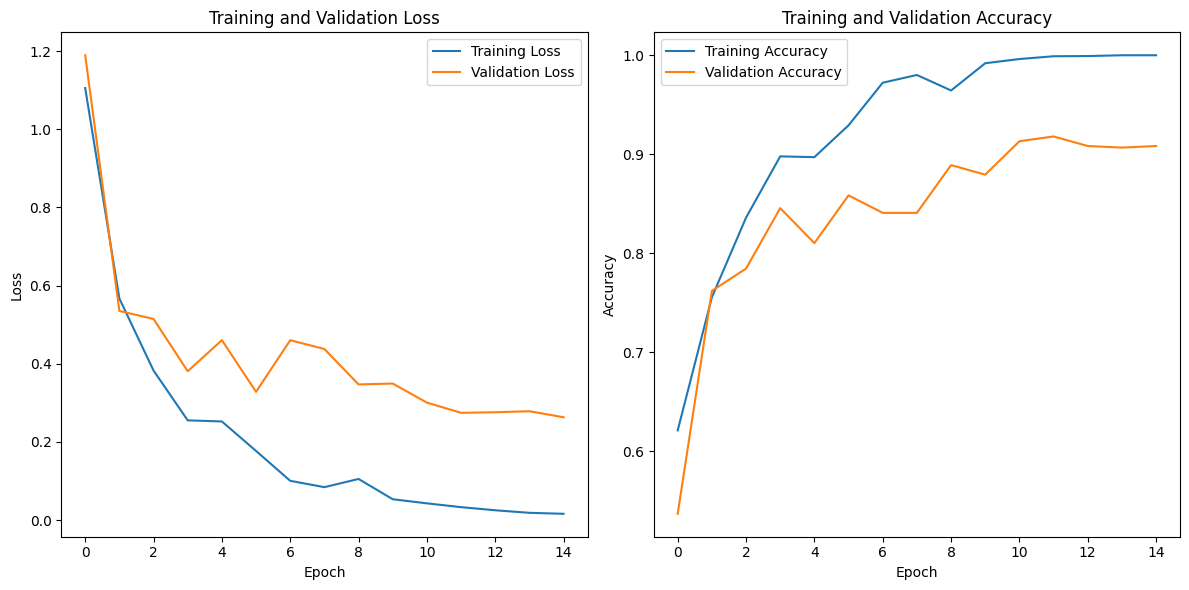

In [ ]:
# Training for Diabetic Retinopathy

# tf.keras.backend.clear_session()
model_diabetes = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

history = model_diabetes.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_validation,y_validation),
                    verbose=1,callbacks=[checkpoint,earlystop])

model_diabetes.save('/content/gdrive/MyDrive/DL_files/diabetes_model.keras')

plot_train_valid_results(history)


In [ ]:
model_diabetes_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/diabetes_model.keras')

In [ ]:
loss,accuracy = model_diabetes_testing.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

20/20 [==============================] - 4s 78ms/step - loss: 0.3813 - accuracy: 0.8923
loss: 0.38132694363594055
Accuracy: 0.8922829627990723


In [ ]:
y_pred = model_diabetes_testing.predict(x_test)

20/20 [==============================] - 3s 71ms/step


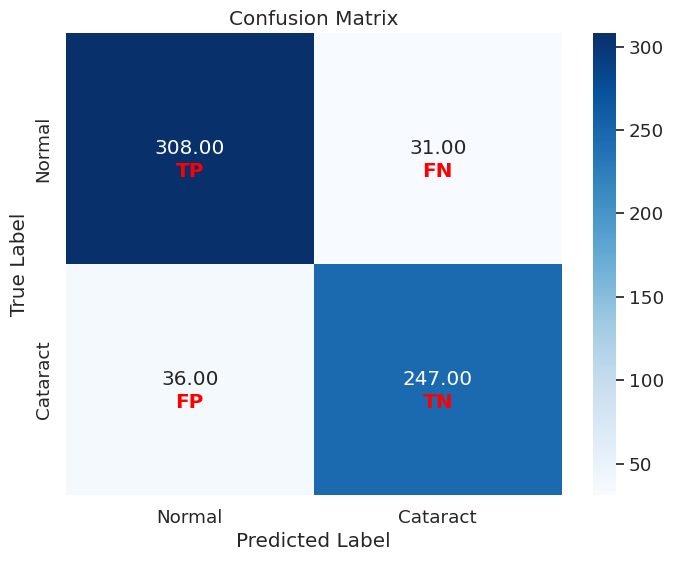

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
plot_cm(cm)

GLAUCOMA

In [ ]:
# LOAD THE DATA

# For binary Normal-Glaucoma
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/glaucoma_dataset.pkl', 'rb') as file:
    dataset_ng = pickle.load(file)

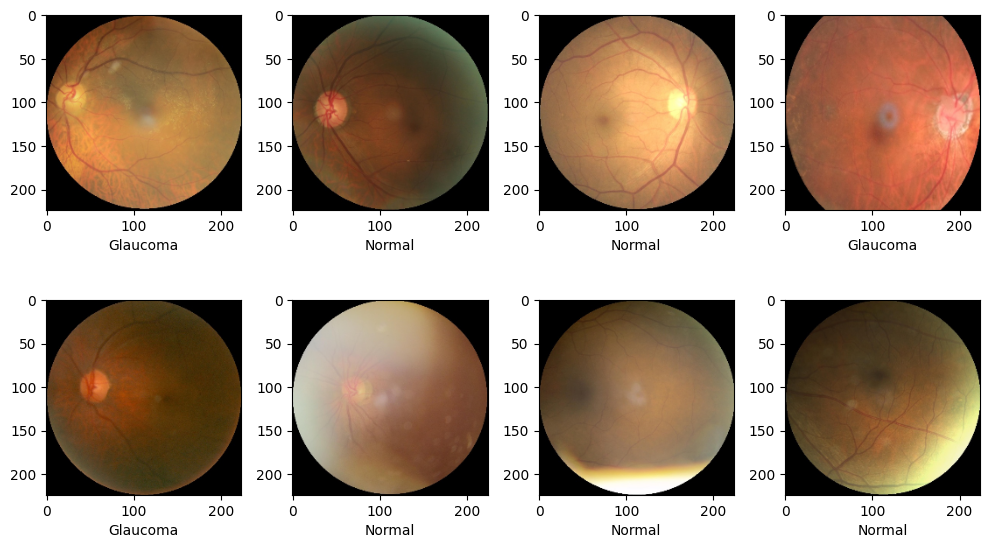

In [ ]:
plot_images(dataset_ng, "Normal", "Glaucoma")


In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test = define_train_test_valid(dataset_ng, image_size)

Epoch 1/15
31/31 [==============================] - ETA: 0s - loss: 2.0000 - accuracy: 0.6412
Epoch 1: val_accuracy improved from -inf to 0.74380, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 21s 234ms/step - loss: 2.0000 - accuracy: 0.6412 - val_loss: 1.0953 - val_accuracy: 0.7438
Epoch 2/15
30/31 [============================>.] - ETA: 0s - loss: 0.5140 - accuracy: 0.8313
Epoch 2: val_accuracy did not improve from 0.74380
31/31 [==============================] - 3s 87ms/step - loss: 0.5131 - accuracy: 0.8314 - val_loss: 0.7115 - val_accuracy: 0.7438
Epoch 3/15
30/31 [============================>.] - ETA: 0s - loss: 0.2081 - accuracy: 0.9219
Epoch 3: val_accuracy did not improve from 0.74380
31/31 [==============================] - 3s 90ms/step - loss: 0.2099 - accuracy: 0.9204 - val_loss: 0.6258 - val_accuracy: 0.7190
Epoch 4/15
30/31 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.8896
Epoch 4: val_accuracy improved from 0.74380 to 0.77686, saving model to vgg19.h5
31/31 [==============================] - 3s 98ms/step - loss: 0.2411 - accuracy: 0.8904 - val_loss: 0.7705 - val_accuracy: 0.7769
Epoch 5/15
30

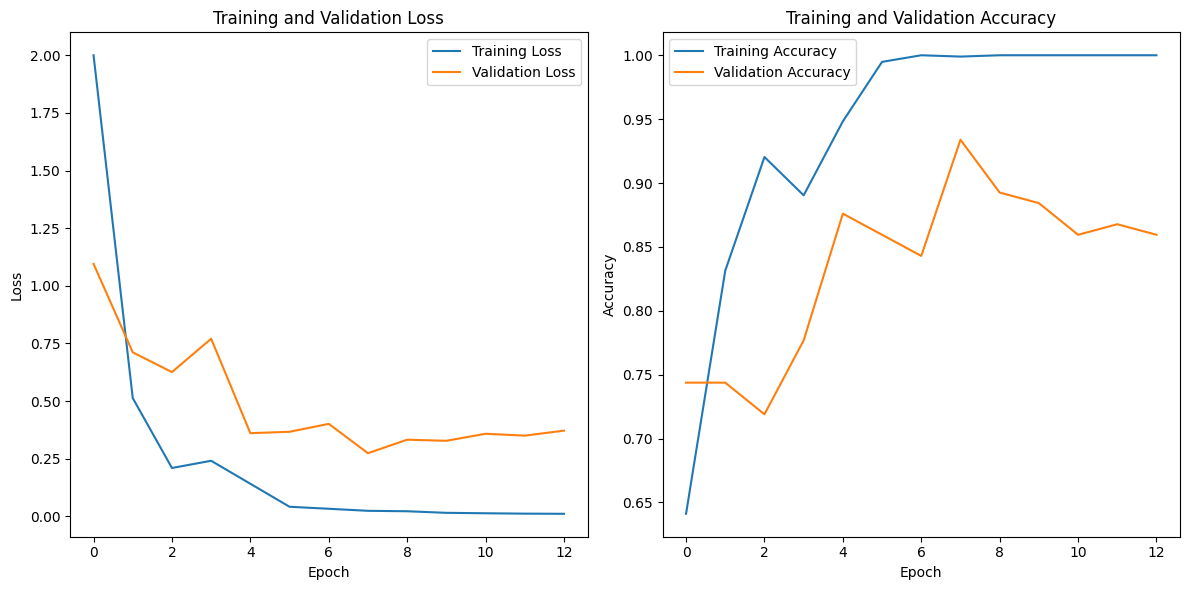

NameError: ignored

In [ ]:
# tf.keras.backend.clear_session()

# model.load_weights(Wsave)

model_glaucoma = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

history = model_glaucoma.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_validation,y_validation),verbose=1,
                             callbacks=[checkpoint,earlystop])

model_glaucoma.save('/content/gdrive/MyDrive/DL_files/glaucoma_model.keras')

plot_train_valid_results(history)

In [ ]:
model_glaucoma_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/glaucoma_model.keras')

In [ ]:
loss,accuracy = model_glaucoma_testing.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 5s 127ms/step - loss: 0.2774 - accuracy: 0.9174
loss: 0.2774253487586975
Accuracy: 0.9173553586006165


In [ ]:
y_pred = model_glaucoma_testing.predict(x_test)

4/4 [==============================] - 4s 94ms/step


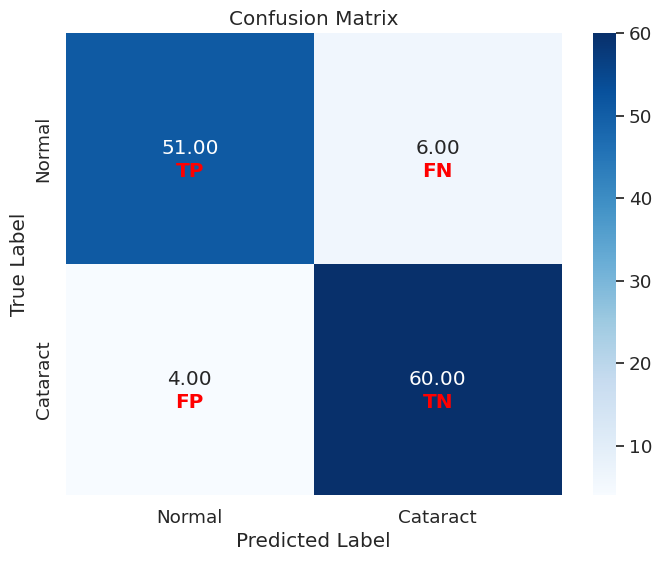

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
plot_cm(cm)

FOR AMD

In [ ]:
# LOAD THE DATASET

# For binary Normal-AMD
with open('/content/gdrive/MyDrive/DL_files/my_new_datasets/AMD_dataset.pkl', 'rb') as file:
    dataset_na = pickle.load(file)

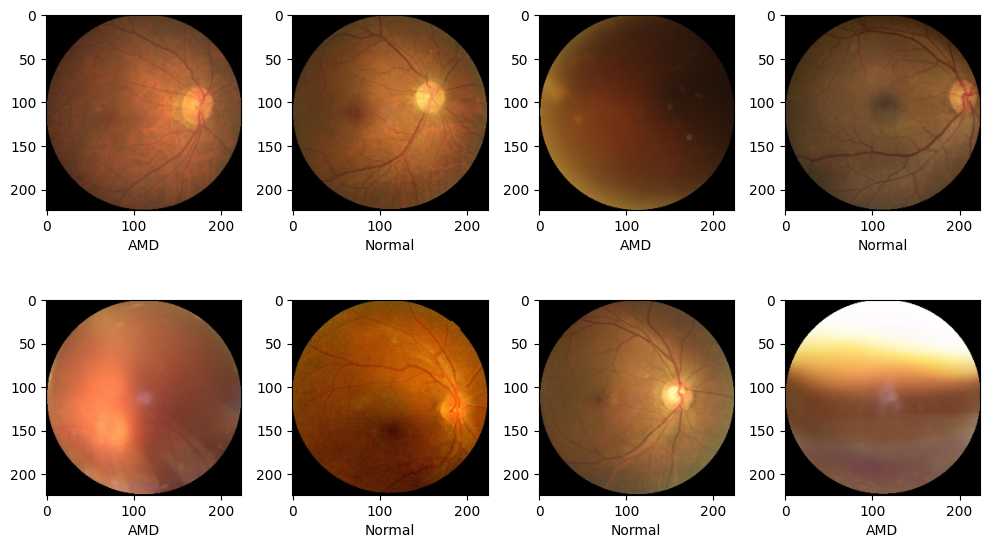

In [ ]:
plot_images(dataset_na, "Normal", "AMD")

In [ ]:
x_train, x_validation, x_test, y_train, y_validation, y_test = define_train_test_valid(dataset_na, image_size)

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 1.9013 - accuracy: 0.7124
Epoch 1: val_accuracy improved from -inf to 0.78302, saving model to vgg19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 20s 226ms/step - loss: 1.9013 - accuracy: 0.7124 - val_loss: 0.7705 - val_accuracy: 0.7830
Epoch 2/15
26/27 [===========================>..] - ETA: 0s - loss: 0.2925 - accuracy: 0.8930
Epoch 2: val_accuracy improved from 0.78302 to 0.91509, saving model to vgg19.h5
27/27 [==============================] - 3s 114ms/step - loss: 0.2938 - accuracy: 0.8935 - val_loss: 0.2362 - val_accuracy: 0.9151
Epoch 3/15
26/27 [===========================>..] - ETA: 0s - loss: 0.0996 - accuracy: 0.9627
Epoch 3: val_accuracy did not improve from 0.91509
27/27 [==============================] - 2s 89ms/step - loss: 0.0990 - accuracy: 0.9633 - val_loss: 0.1987 - val_accuracy: 0.9151
Epoch 4/15
26/27 [===========================>..] - ETA: 0s - loss: 0.0480 - accuracy: 0.9904
Epoch 4: val_accuracy improved from 0.91509 to 0.93396, saving model to vgg19.h5
27/27 [==============================] - 3s 99ms/step - loss: 0.0475 - accuracy: 0.9905 - val_loss: 0.1888 - val

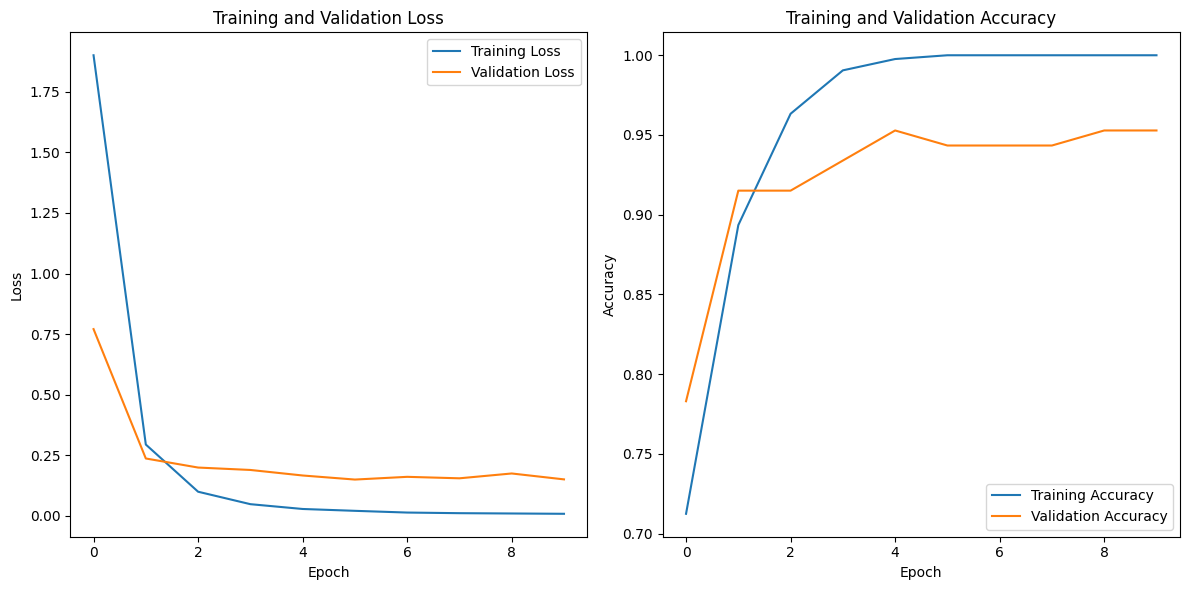

In [ ]:
model_AMD = keras.models.load_model('/content/gdrive/MyDrive/DL_files/binary_model.keras')

history = model_AMD.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_validation,y_validation),verbose=1,
                             callbacks=[checkpoint,earlystop])

model_AMD.save('/content/gdrive/MyDrive/DL_files/AMD_model.keras')

plot_train_valid_results(history)

In [ ]:
model_AMD_testing = keras.models.load_model('/content/gdrive/MyDrive/DL_files/AMD_model.keras')

In [ ]:
loss,accuracy = model_AMD_testing.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

4/4 [==============================] - 2s 71ms/step - loss: 0.1390 - accuracy: 0.9528
loss: 0.13899214565753937
Accuracy: 0.9528301954269409


In [ ]:
y_pred = model_AMD_testing.predict(x_test)

4/4 [==============================] - 2s 86ms/step


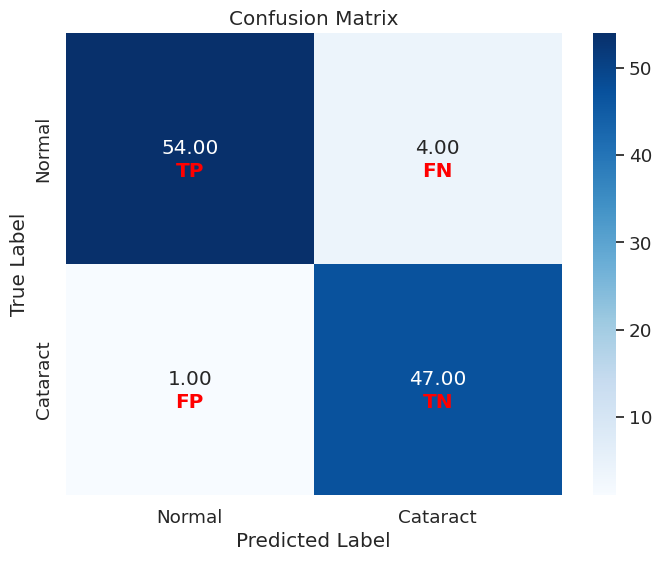

In [ ]:
cm = confusion_matrix(y_test, np.round(y_pred))
plot_cm(cm)